In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import sys
#path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn'
path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0,path_to_mavenn)

# Load mavenn
import mavenn

In [2]:
# Load example data (WHICH CONTAINS DOUBLE MUTANTS ONLY!)
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 26,364
training + validation N: 504,373


,set,dist,input_ct,selected_ct,y,x
0,training,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
5,training,2,108,1,-6.557858,AGKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
6,training,2,48,93,0.150206,AHKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
7,training,2,119,49,-2.052708,AIKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
8,training,2,252,79,-2.450739,ALKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
9,training,2,110,116,-0.713724,AMKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
len(data_df)

504373

In [5]:
model = mavenn.load('gb1_additive_ge_2021.12.28.17h.21m')

Model loaded from these files:
	gb1_additive_ge_2021.12.28.17h.21m.pickle
	gb1_additive_ge_2021.12.28.17h.21m.h5


### Single bootstrapped model

In [17]:
gb1_sim_model = model.bootstrap(data_df=data_df,num_models=1)

Training set   :  477,854 observations (  94.74%)
Validation set :   26,519 observations (   5.26%)
Test set       :        0 observations (   0.00%)
-------------------------------------------------
Total dataset  :  504,373 observations ( 100.00%)

training model 0 ...
N = 504,373 observations set as training data.
Using 5.3% for validation.
Data shuffled.
Time to set data: 25.2 sec.


Using TensorFlow backend.
Exception ignored in: <bound method tqdm.__del__ of <tqdm.auto.tqdm object at 0x7facfdcc6cf8>>
Traceback (most recent call last):
  File "/Users/tareen/miniconda3/lib/python3.6/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/Users/tareen/miniconda3/lib/python3.6/site-packages/tqdm/notebook.py", line 289, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Training time: 348.4 seconds


In [20]:
gb1_sim_model[0].save('gb1_ge_sim')

Model saved to these files:
	gb1_ge_sim.pickle
	gb1_ge_sim.h5


In [6]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

On test data:
I_var_test: 2.189 +- 0.013 bits
I_pred_test: 2.226 +- 0.006 bits


Text(0.5, 1.0, 'training history - subsampled model')

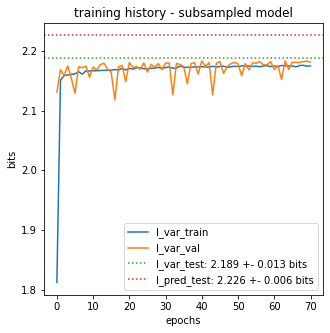

In [8]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[5,5])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label=f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')
ax.axhline(I_pred, color='C3', linestyle=':', label=f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training history - subsampled model')

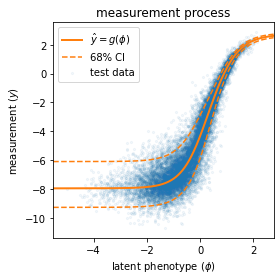

In [9]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.05, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

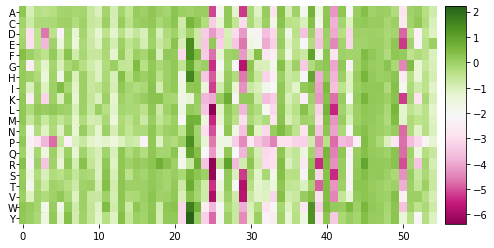

In [11]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap(values=theta['theta_lc'],
                        alphabet=theta['alphabet'],
                        ax=ax,
                        cmap='PiYG');

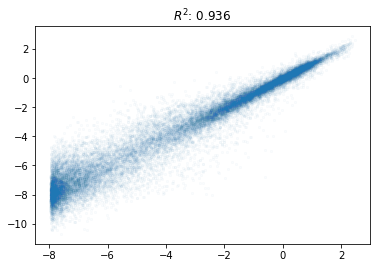

In [12]:
yhat_test = model.x_to_yhat(x_test)
Rsq = np.corrcoef(y_test,yhat_test)[0][1]**2

plt.title('$R^2$: '+str(Rsq)[0:5])
plt.scatter(yhat_test,y_test,s=5,alpha=0.02)

In [13]:
theta_lc = model.get_theta()['theta_lc']
theta_lc = theta_lc[~np.isnan(theta_lc)]